In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import pandas as pd

def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

# Visualize Traj Forecasting Results

### Noisy data in

In [2]:
dataset = 'trajectory' # choose 'healthcare' or 'airquality'
datafolder = 'traj_forecasting_20240808_162748' # set the folder name
nsample = 5 # number of generated sample

segment_id = 34 # target segment to visualize
local_veh_id = 50 # target local vehicle id to visualize
path = './save/'+datafolder+'/seg' + str(segment_id) + '_localvehid' + str(local_veh_id) + '_nsample' + str(nsample) + '.pk'
# path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk'

with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length


qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

In [3]:
resultfolder = 'traj_forecasting_20240808_162748'
result_path = './save/'+resultfolder+'/result_nsample' + str(nsample) + '.pk'
with open(result_path, 'rb') as f:
    RMSE, MAE, _ = pickle.load(f) # the last metric is reserved

In [4]:
print(samples.shape)
print(quantiles_imp[2][0,:,1])

torch.Size([12, 5, 50, 3])
[-0.7880532  -0.6406478  -0.788051   -0.788051    0.19558947  0.4111446
 -0.78797805 -0.69870365 -0.7723071  -0.78797805 -0.7879802  -1.4552813
 -1.0840545  -1.158756   -0.787978   -0.788051   -0.7879802  -1.4532207
 -1.1299908  -0.7879802  -0.40986386 -0.6278089  -0.7879802  -0.8012783
 -0.7250673  -0.8147224  -0.8147224  -0.81464946 -0.9073286  -0.9770925
 -0.81464946 -1.1287862  -0.81464946 -0.780164   -0.8298659  -0.89071447
 -0.8628719  -0.8564833  -0.74575156 -0.74575156 -0.7866818  -0.8126035
 -0.81819254 -0.82019705 -0.80418646 -0.8158059  -0.78211564 -0.81247133
 -0.787948   -0.8118097 ]


In [5]:
print(f"RMSE = {RMSE}")
print(f"MAE = {MAE}")

RMSE = 16.7303063542355
MAE = 4.125765091600647


In [6]:
print(all_target_np.shape)
print(all_evalpoint_np.shape)
print(all_given_np.shape)

(12, 50, 3)
(12, 50, 3)
(12, 50, 3)


In [7]:
def visualize_trajectory(dataind, nrows=2, ncols=3):
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18.0, 6.0))
    fig.delaxes(axes[-1][-1])

    for k in range(K):
        df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
        df2 = df2[df2.y != 0]
        row = k // ncols
        col = k % ncols
        axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
        # axes[row][col].fill_between(range(0,L), quantiles_imp[1][dataind,:,k],quantiles_imp[3][dataind,:,k],
        #                 color='g', alpha=0.3) # 1Q and 3Q
        axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
        plt.setp(axes[row,col], xlabel='time in 0.1s')
        if col == 0:
            plt.setp(axes[row,col], ylabel='position')
        elif col == 1:
            plt.setp(axes[row,col], ylabel='speed')
        elif col == 2:
            plt.setp(axes[row,col], ylabel='acceleration')
        axes[row,col].spines[['right', 'top']].set_visible(False)

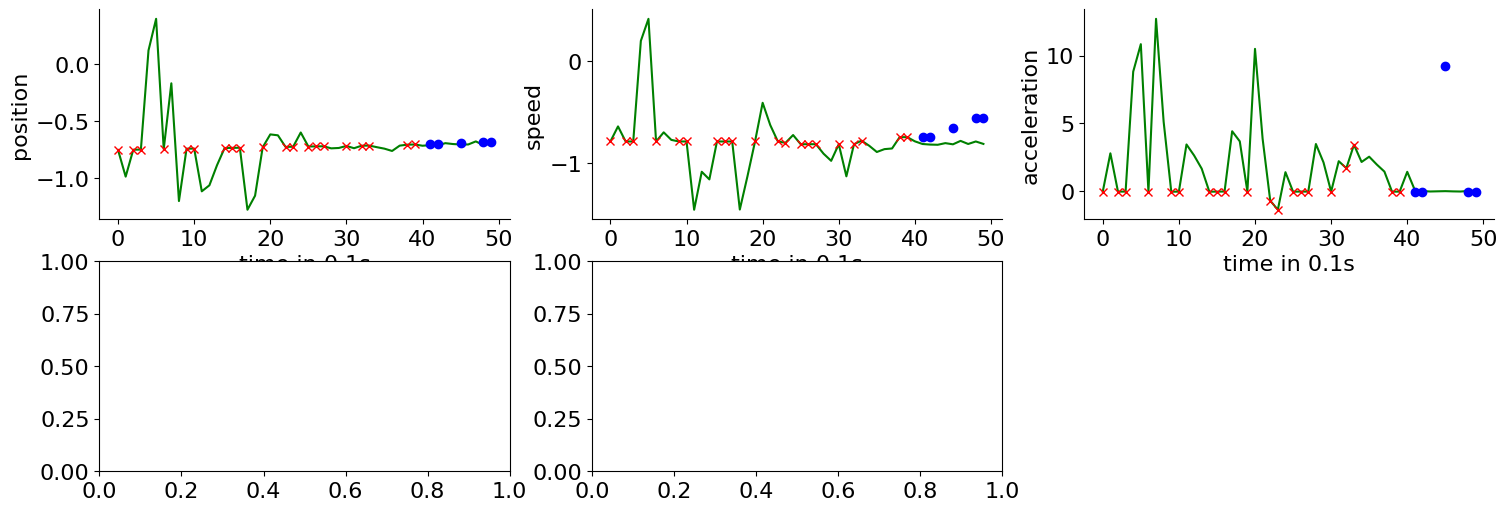

In [8]:
visualize_trajectory(dataind=0) # change to visualize a different sample

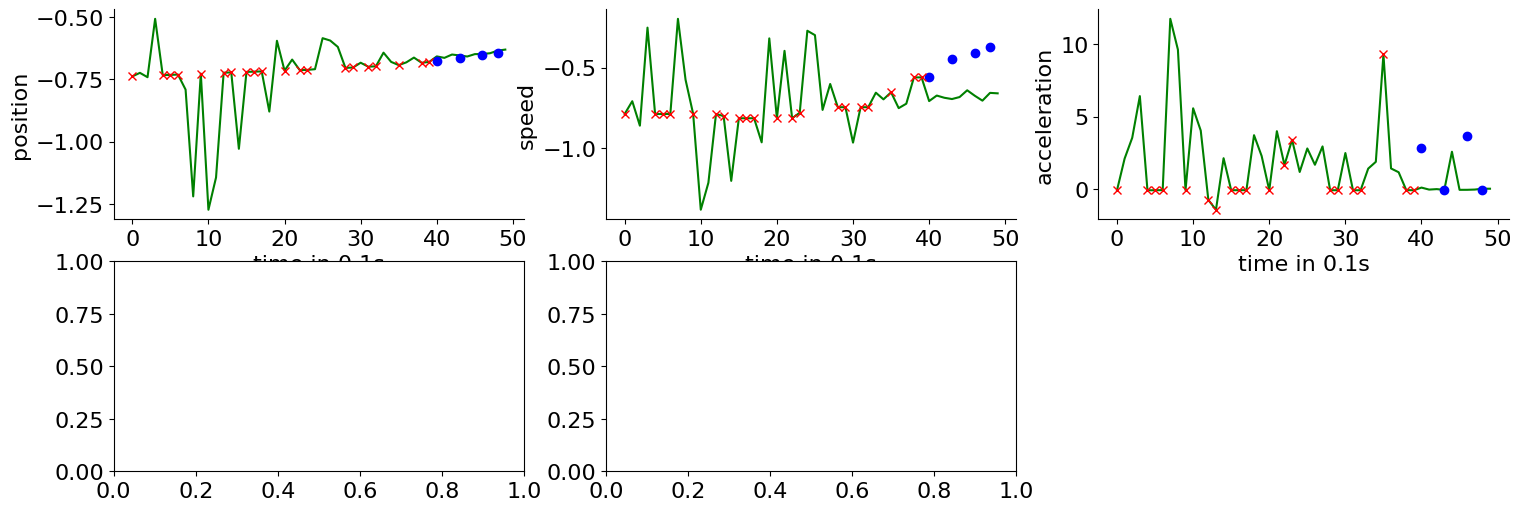

In [9]:
visualize_trajectory(dataind=1) # change to visualize a different sample

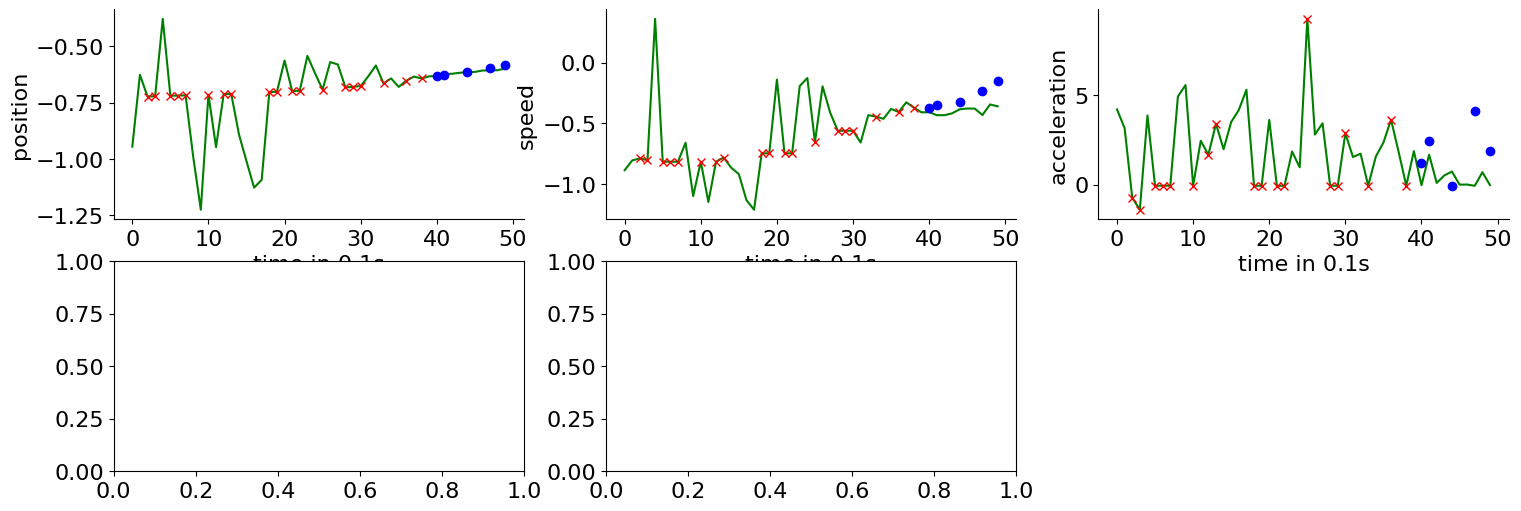

In [10]:
visualize_trajectory(dataind=2) # change to visualize a different sample

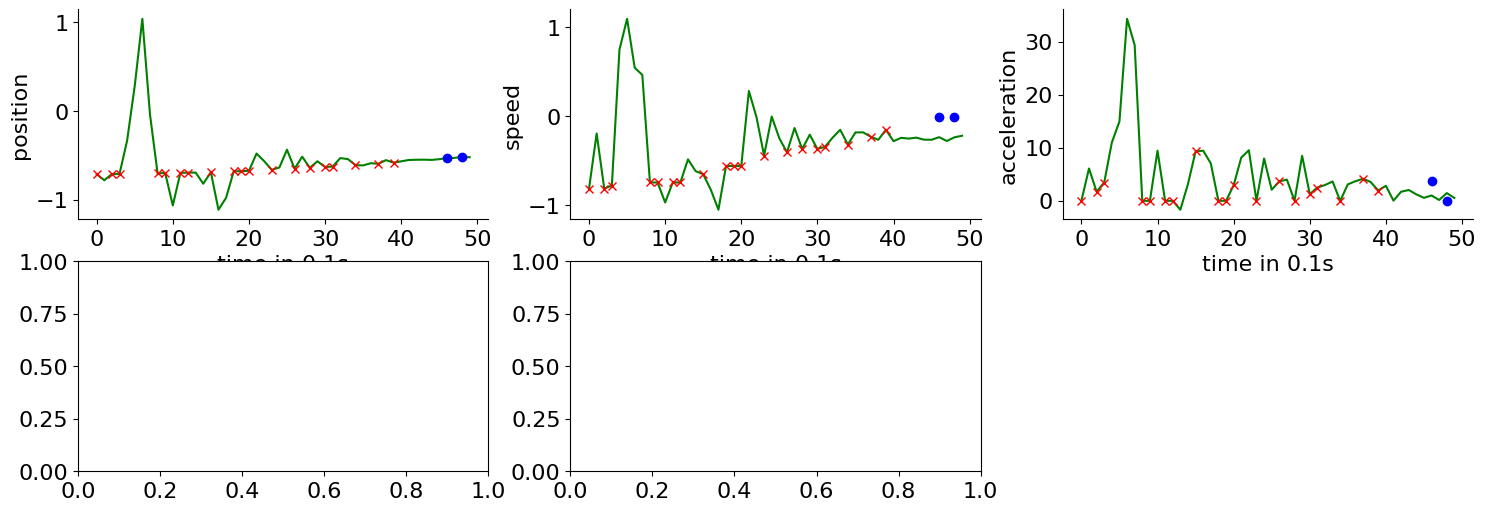

In [11]:
visualize_trajectory(dataind=3) # change to visualize a different sample

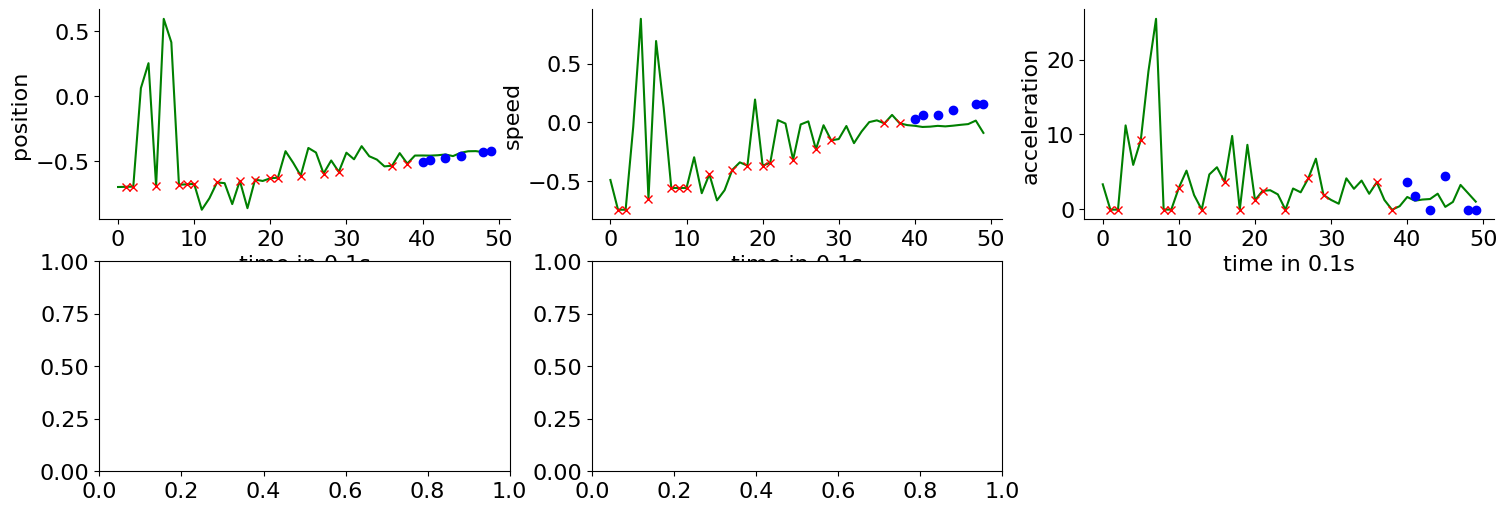

In [12]:
visualize_trajectory(dataind=4) # change to visualize a different sample

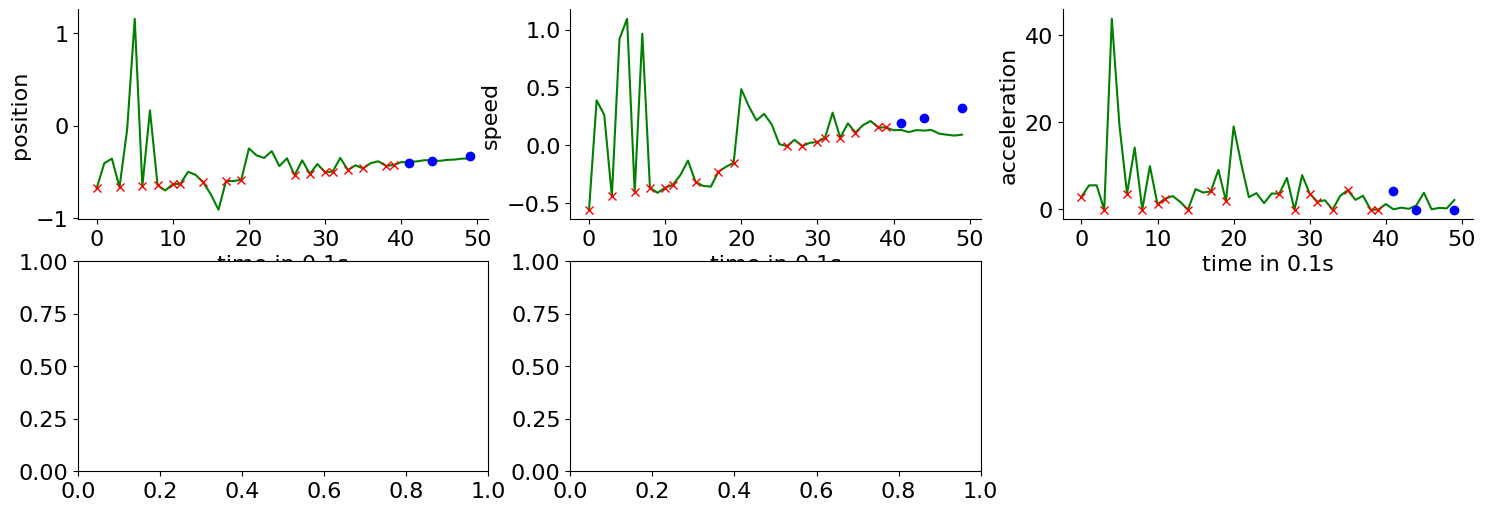

In [13]:
visualize_trajectory(dataind=5) # change to visualize a different sample

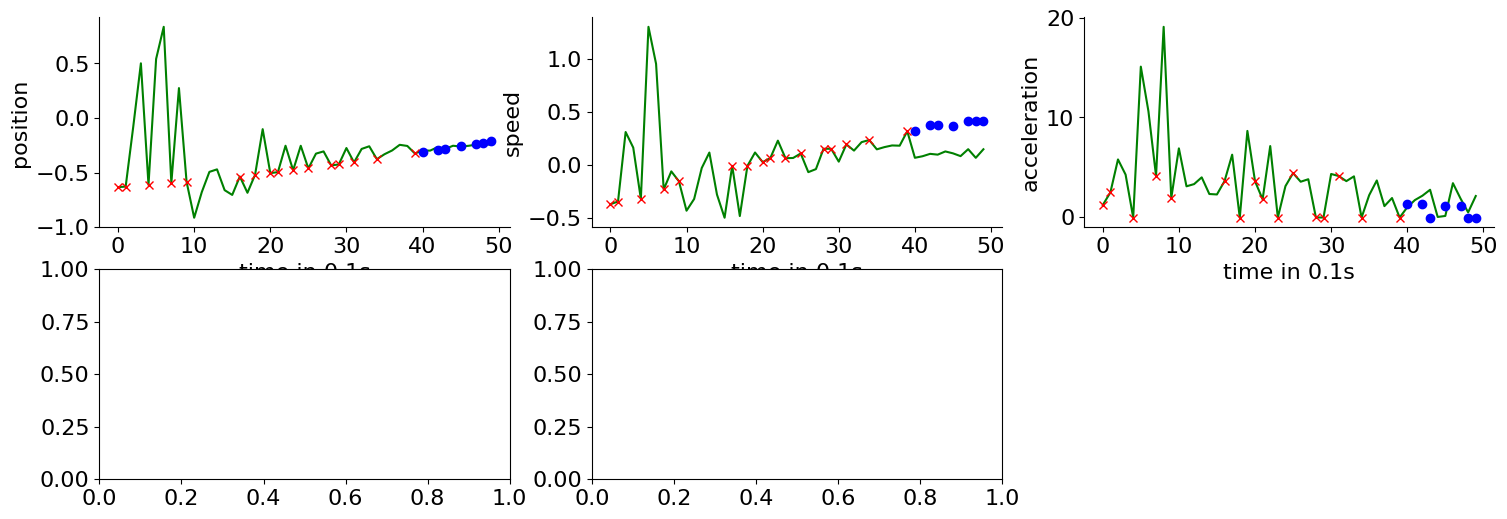

In [14]:
visualize_trajectory(dataind=6) # change to visualize a different sample

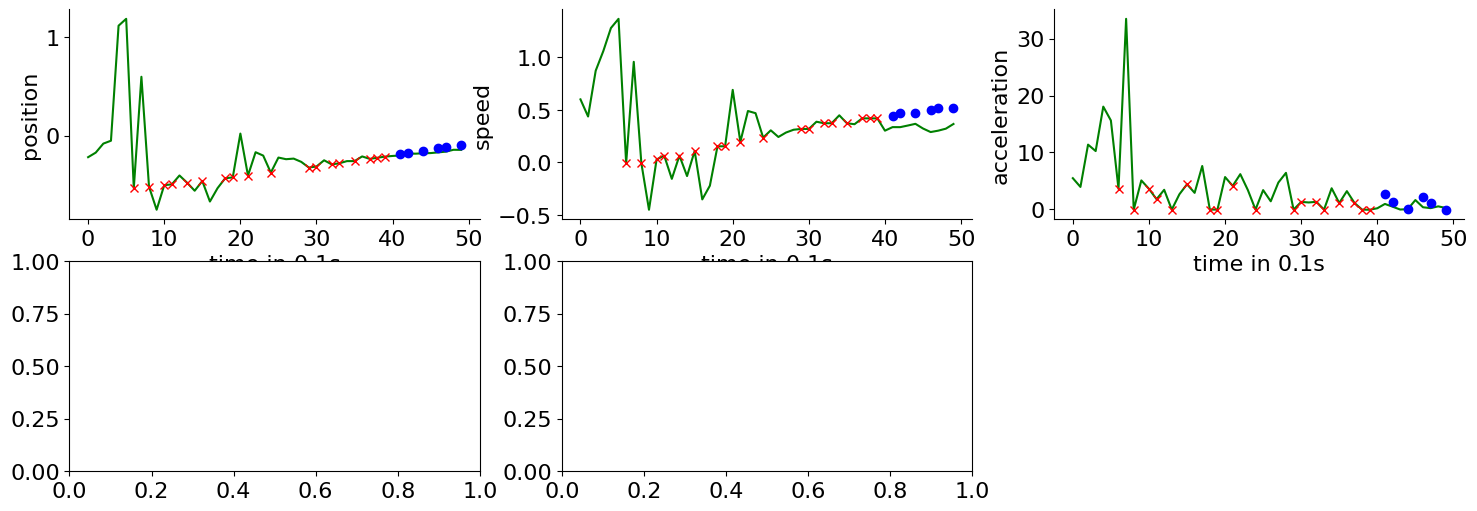

In [15]:
visualize_trajectory(dataind=7) # change to visualize a different sample

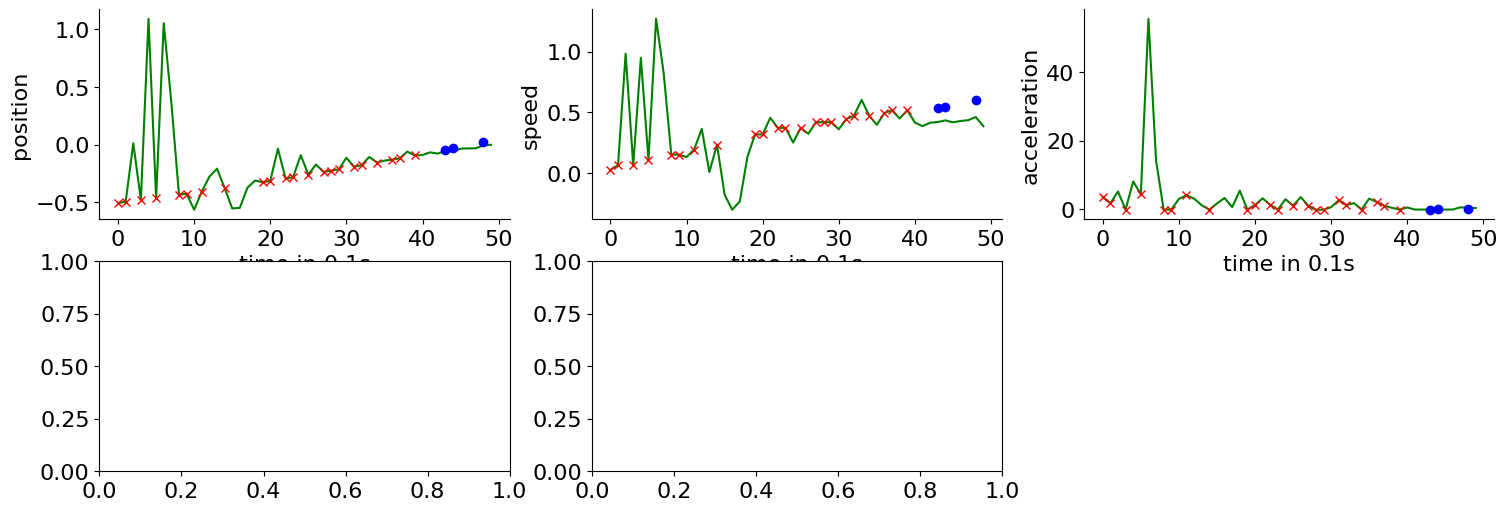

In [16]:
visualize_trajectory(dataind=8) # change to visualize a different sample

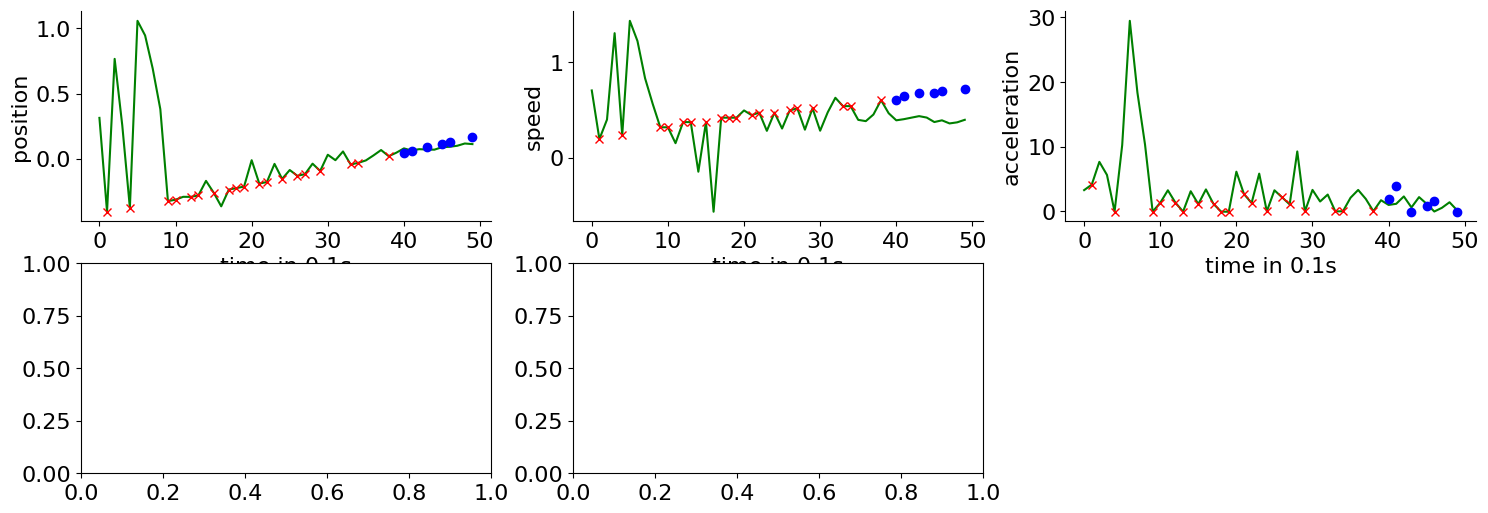

In [17]:
visualize_trajectory(dataind=9) # change to visualize a different sample

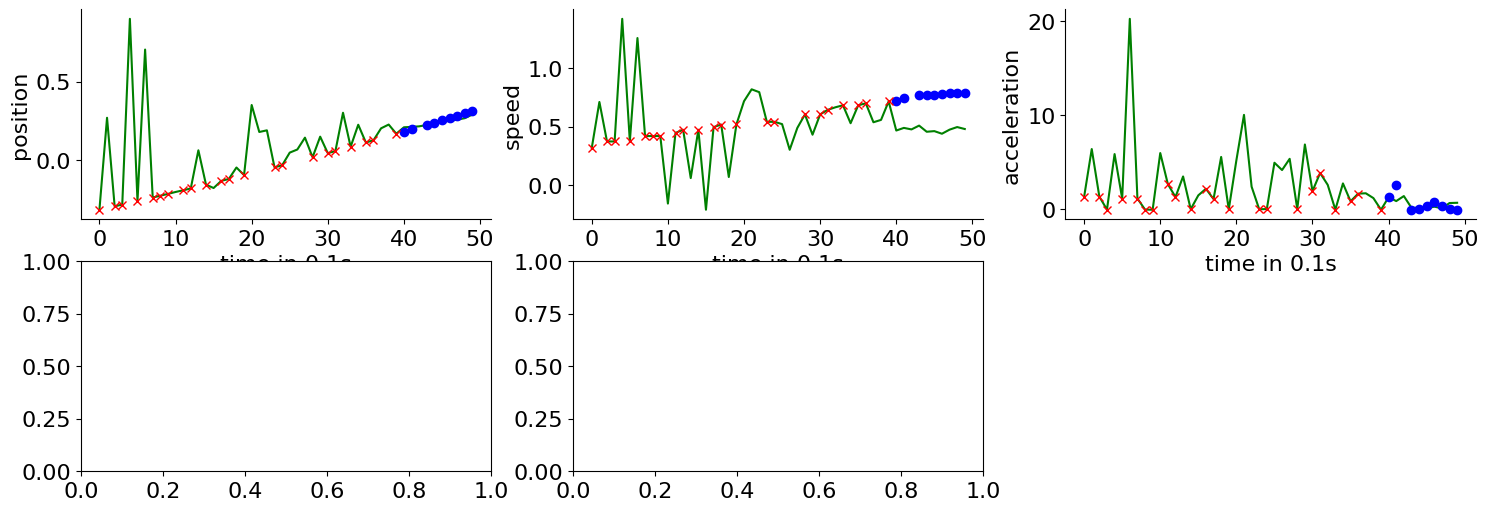

In [18]:
visualize_trajectory(dataind=10) # change to visualize a different sample

### Clean data in

In [19]:
dataset = 'trajectory' # choose 'healthcare' or 'airquality'
datafolder = 'traj_forecasting_20240731_172548' # set the folder name
nsample = 5 # number of generated sample

segment_id = 34 # target segment to visualize
local_veh_id = 51 # target local vehicle id to visualize
path = './save/'+datafolder+'/seg' + str(segment_id) + '_localvehid' + str(local_veh_id) + '_nsample' + str(nsample) + '.pk'
# path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk'

with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length


qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

In [20]:
resultfolder = 'traj_forecasting_20240731_172548'
result_path = './save/'+resultfolder+'/result_nsample' + str(nsample) + '.pk'
with open(result_path, 'rb') as f:
    RMSE, MAE, _ = pickle.load(f) # the last metric is reserved

In [21]:
print(f"RMSE = {RMSE}")
print(f"MAE = {MAE}")

RMSE = 37.29991607115016
MAE = 13.500765871721814


In [22]:
print(all_target_np.shape)
print(all_evalpoint_np.shape)
print(all_given_np.shape)

(14, 50, 3)
(14, 50, 3)
(14, 50, 3)


In [23]:
def visualize_trajectory(dataind, nrows=2, ncols=3):
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18.0, 6.0))
    fig.delaxes(axes[-1][-1])

    for k in range(K):
        df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
        df2 = df2[df2.y != 0]
        row = k // ncols
        col = k % ncols
        axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
        # axes[row][col].fill_between(range(0,L), quantiles_imp[1][dataind,:,k],quantiles_imp[3][dataind,:,k],
        #                 color='g', alpha=0.3) # 1Q and 3Q
        axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
        plt.setp(axes[row,col], xlabel='time in 0.1s')
        if col == 0:
            plt.setp(axes[row,col], ylabel='position')
        elif col == 1:
            plt.setp(axes[row,col], ylabel='speed')
        elif col == 2:
            plt.setp(axes[row,col], ylabel='acceleration')
        axes[row,col].spines[['right', 'top']].set_visible(False)

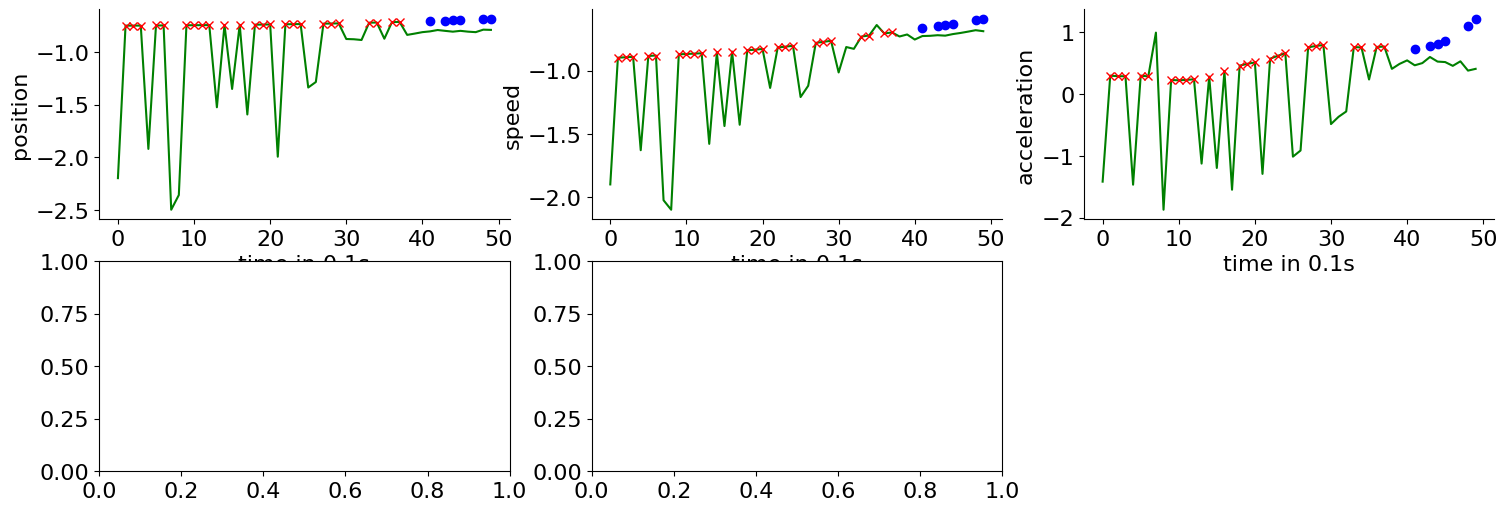

In [24]:
visualize_trajectory(dataind=0) # change to visualize a different sample

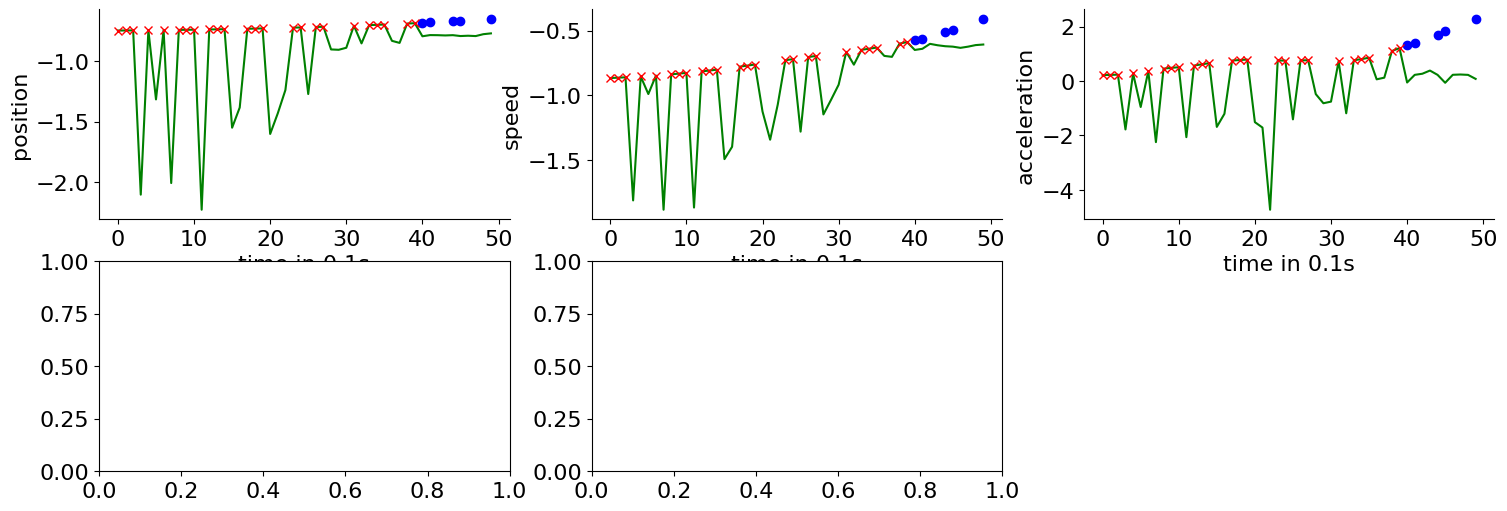

In [25]:
visualize_trajectory(dataind=1) # change to visualize a different sample

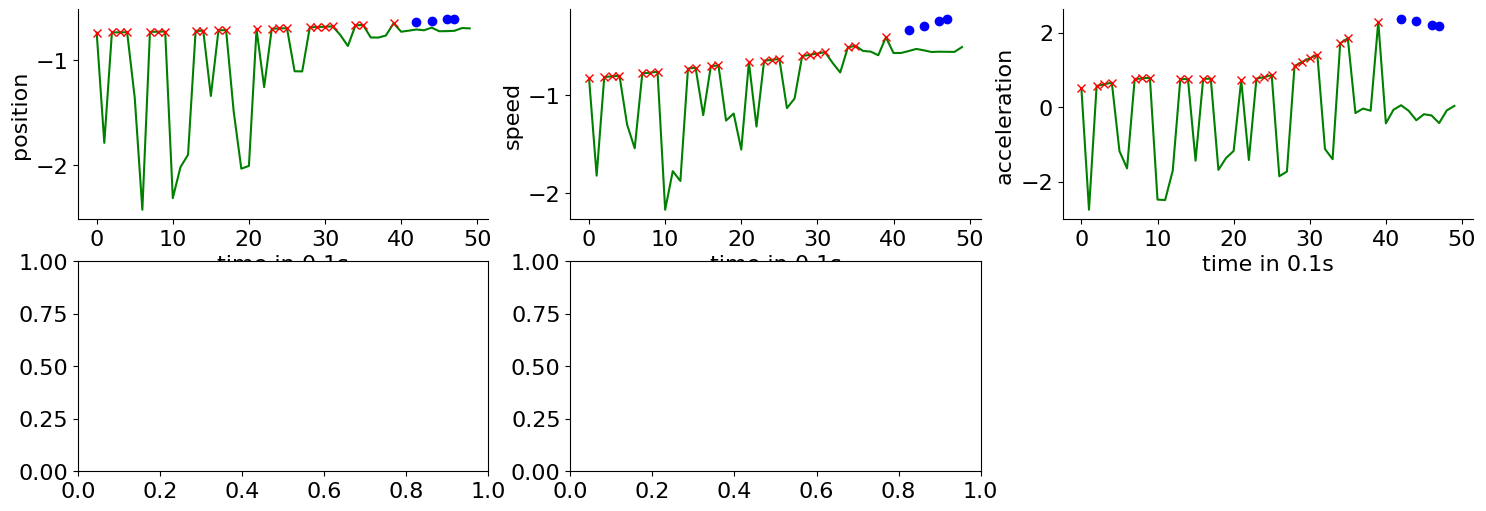

In [26]:
visualize_trajectory(dataind=2) # change to visualize a different sample

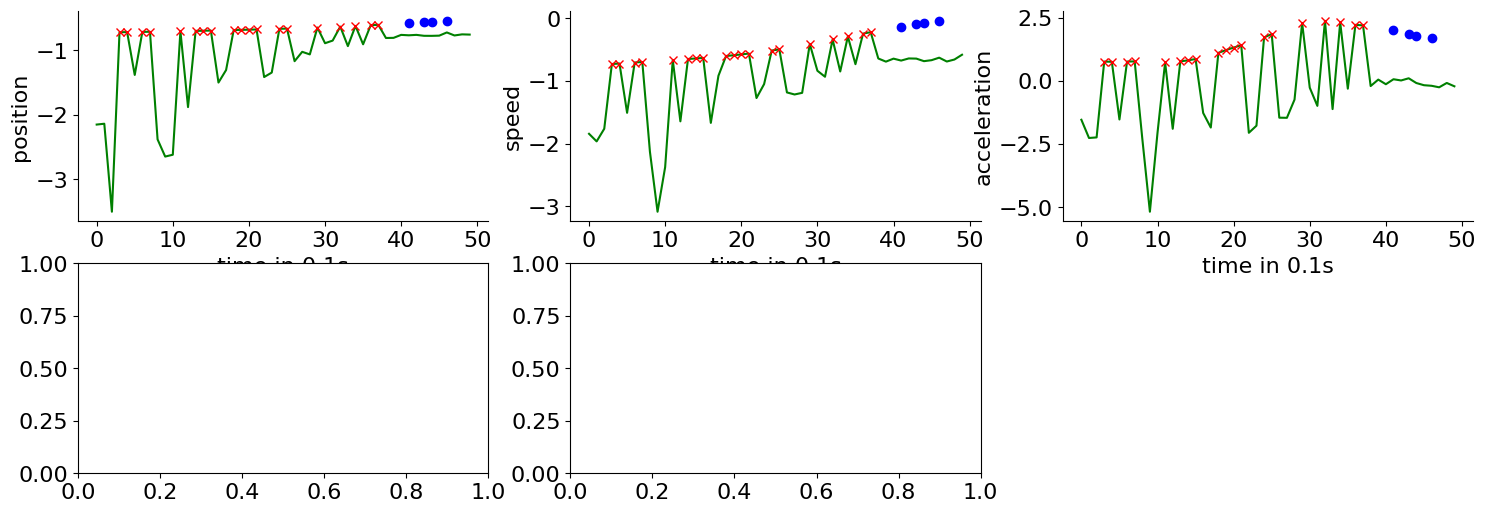

In [27]:
visualize_trajectory(dataind=3) # change to visualize a different sample

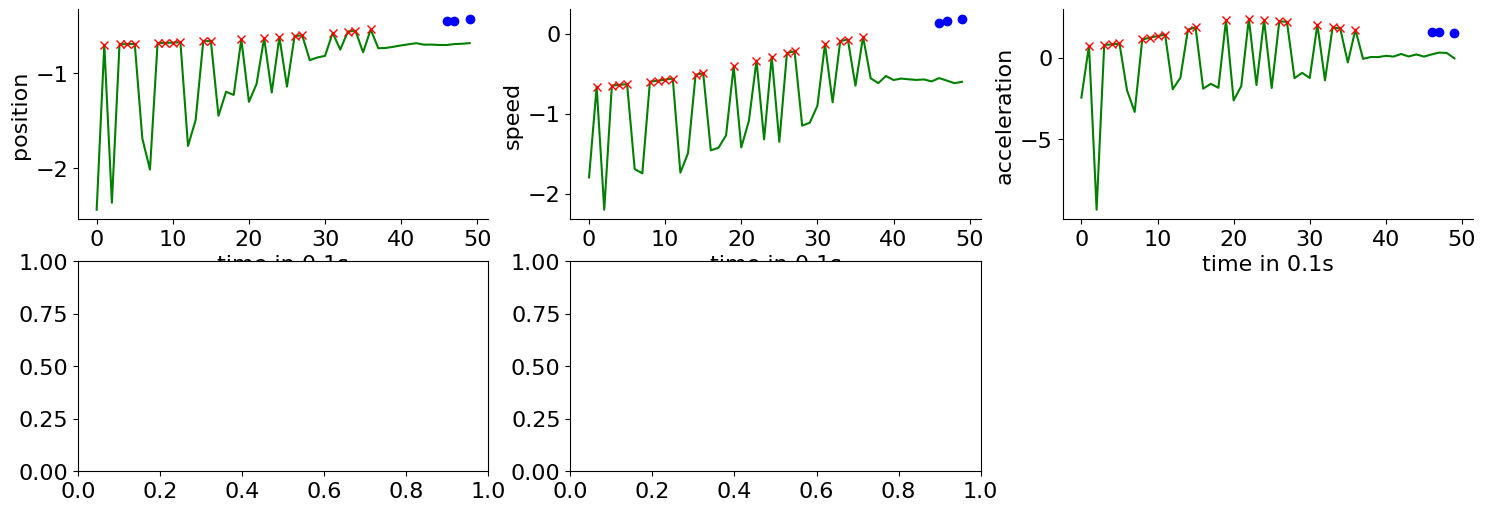

In [28]:
visualize_trajectory(dataind=4) # change to visualize a different sample

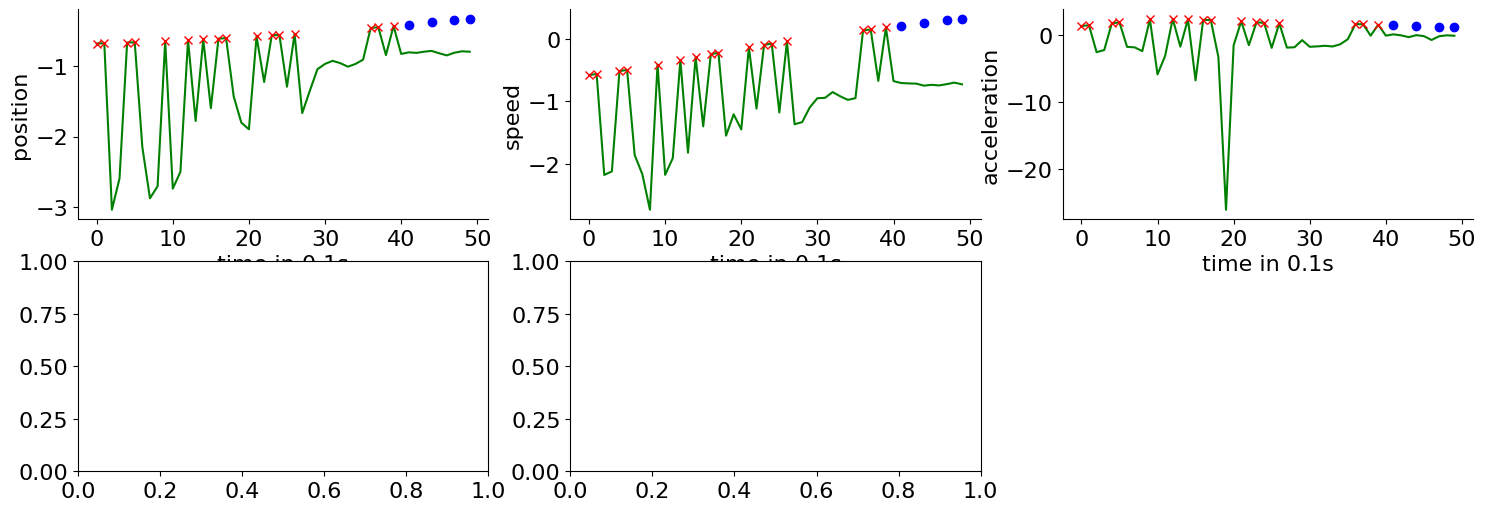

In [29]:
visualize_trajectory(dataind=5) # change to visualize a different sample

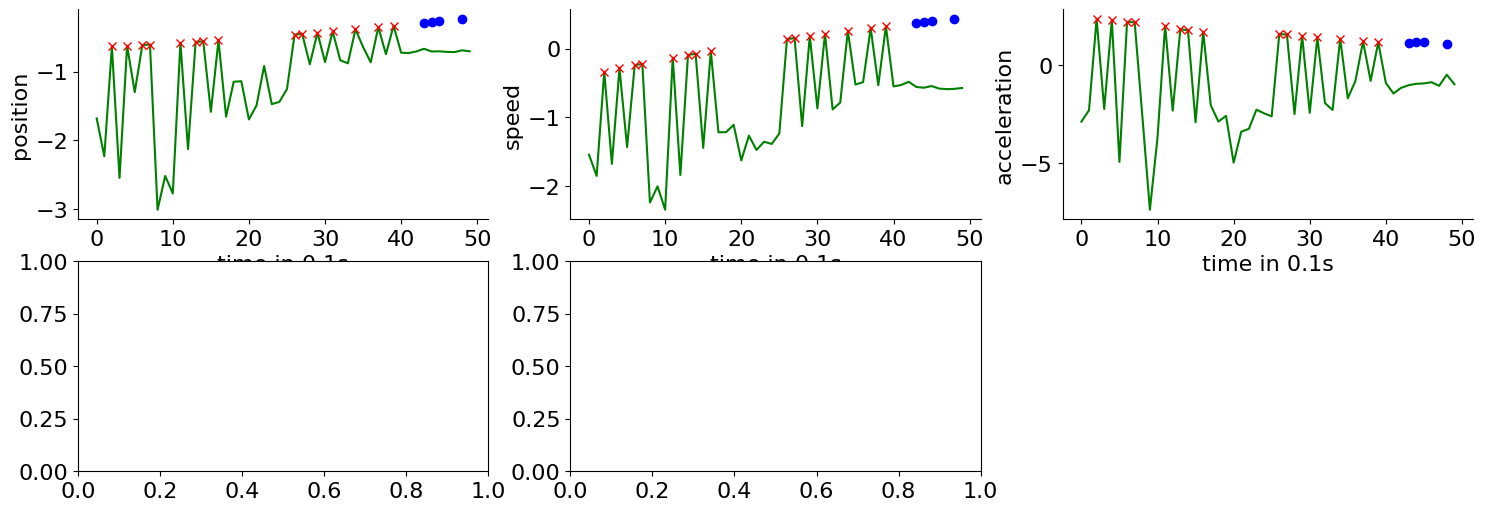

In [30]:
visualize_trajectory(dataind=6) # change to visualize a different sample

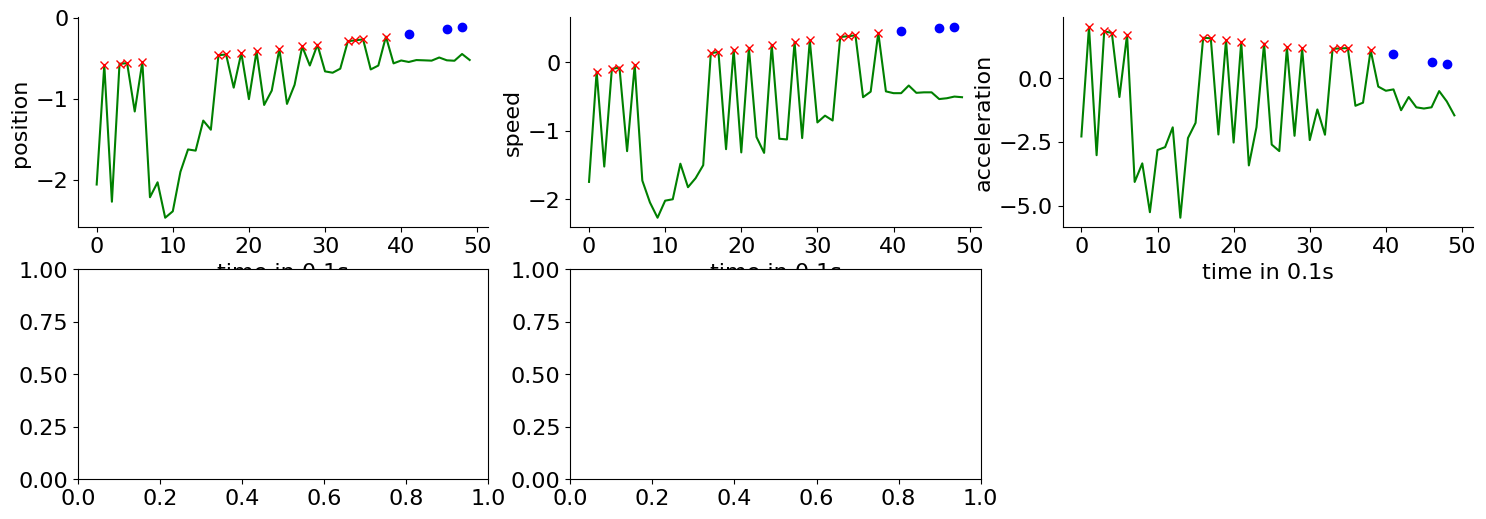

In [31]:
visualize_trajectory(dataind=7) # change to visualize a different sample

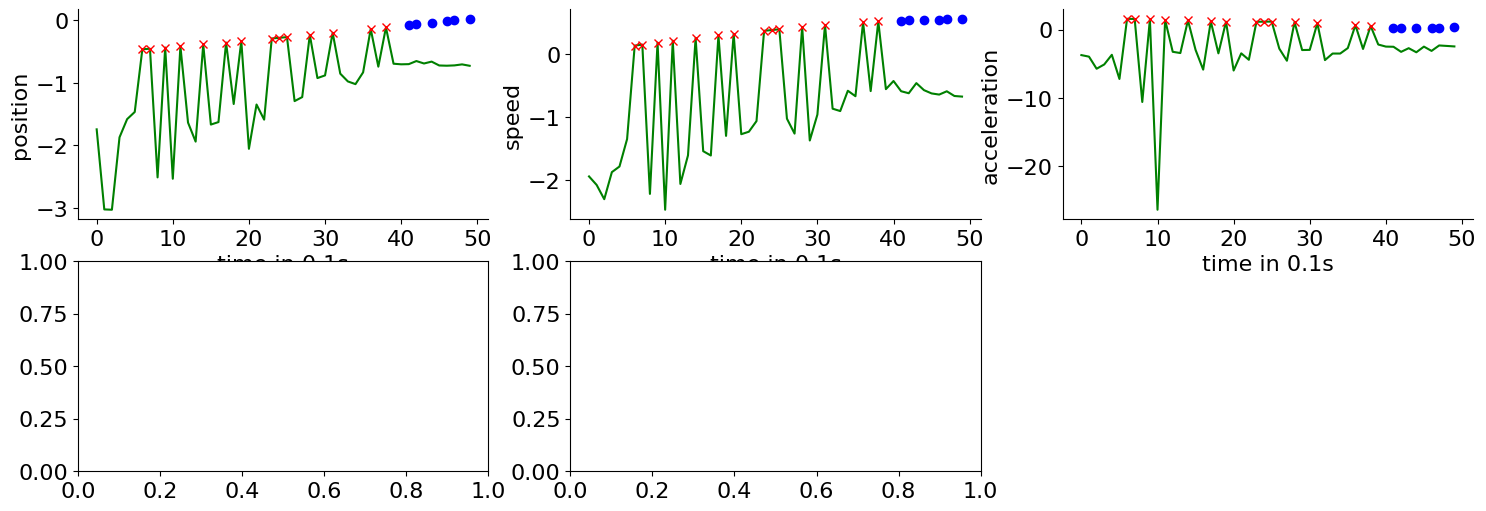

In [32]:
visualize_trajectory(dataind=8) # change to visualize a different sample

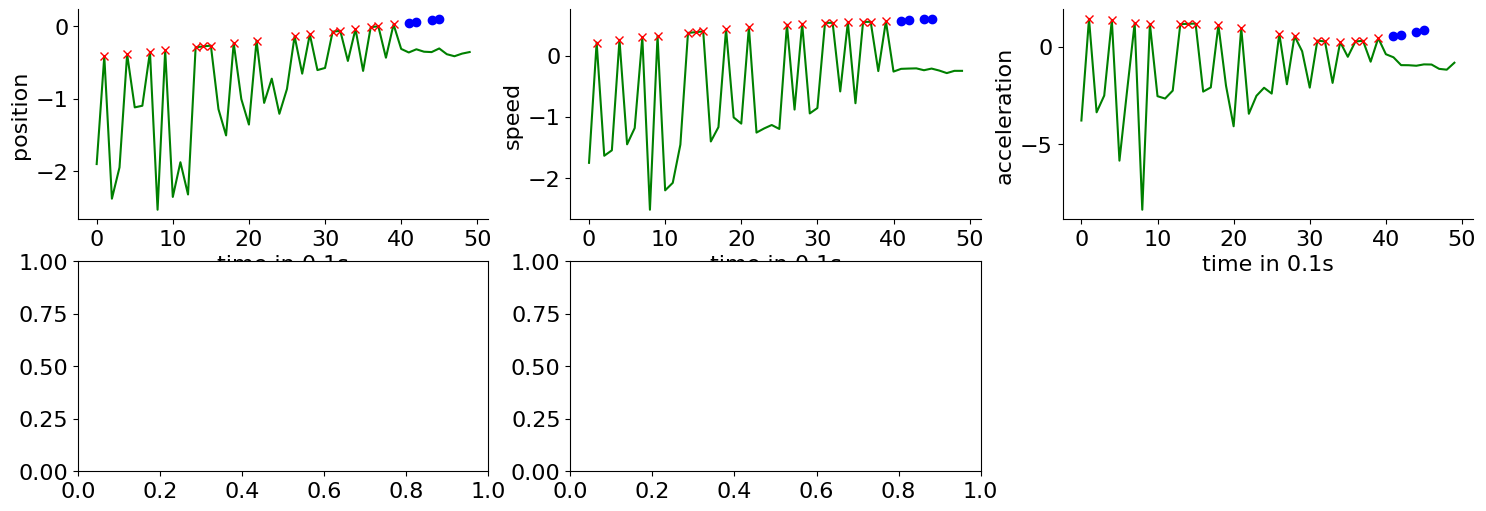

In [33]:
visualize_trajectory(dataind=9) # change to visualize a different sample

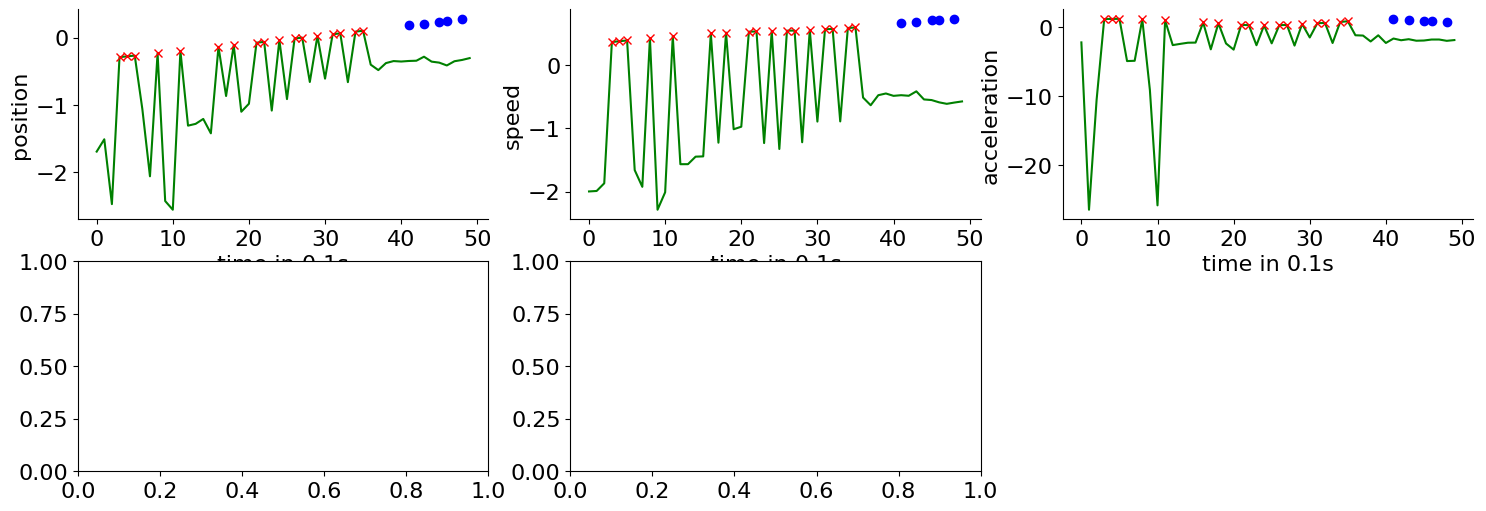

In [34]:
visualize_trajectory(dataind=10) # change to visualize a different sample

# Visualize Traj Imputation Results

In [ ]:
dataset = 'trajectory' # choose 'healthcare' or 'airquality'
datafolder = 'traj_imputation_20240217_151030' # set the folder name
nsample = 5 # number of generated sample

segment_id = 3 # target segment to visualize
path = './save/'+datafolder+'/segment' + str(segment_id) + '_generated_outputs_nsample' + str(nsample) + '.pk'
# path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk'

with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length


qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)



result_path = './save/'+datafolder+'/result_nsample' + str(nsample) + '.pk'
with open(result_path, 'rb') as f:
    RMSE, MAE, _ = pickle.load(f) # the last metric is reserved

In [ ]:
print(samples.shape)
print(quantiles_imp[2][0,:,1])

torch.Size([19, 5, 10, 3])
[0.1298409  0.12984791 0.12983958 0.12983954 0.12983878 0.12983547
 0.12985533 0.12987074 0.12985031 0.1298142 ]


In [ ]:
print(f"RMSE = {RMSE}")
print(f"MAE = {MAE}")

RMSE = 104.24134156689786
MAE = 85.89873046875


In [ ]:
all_target_np.shape

(19, 10, 3)

In [ ]:
def visualize_trajectory(dataind, nrows=2, ncols=3):
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(18.0, 6.0))
    fig.delaxes(axes[-1][-1])

    for k in range(K):
        df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
        df2 = df2[df2.y != 0]
        row = k // ncols
        col = k % ncols
        axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
        axes[row][col].fill_between(range(0,L), quantiles_imp[1][dataind,:,k],quantiles_imp[3][dataind,:,k],
                        color='g', alpha=0.3) # 1Q and 3Q
        axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
        plt.setp(axes[row,col], xlabel='time in 0.1s')
        if col == 0:
            plt.setp(axes[row,col], ylabel='position')
        elif col == 1:
            plt.setp(axes[row,col], ylabel='speed')
        elif col == 2:
            plt.setp(axes[row,col], ylabel='acceleration')
        axes[row,col].spines[['right', 'top']].set_visible(False)

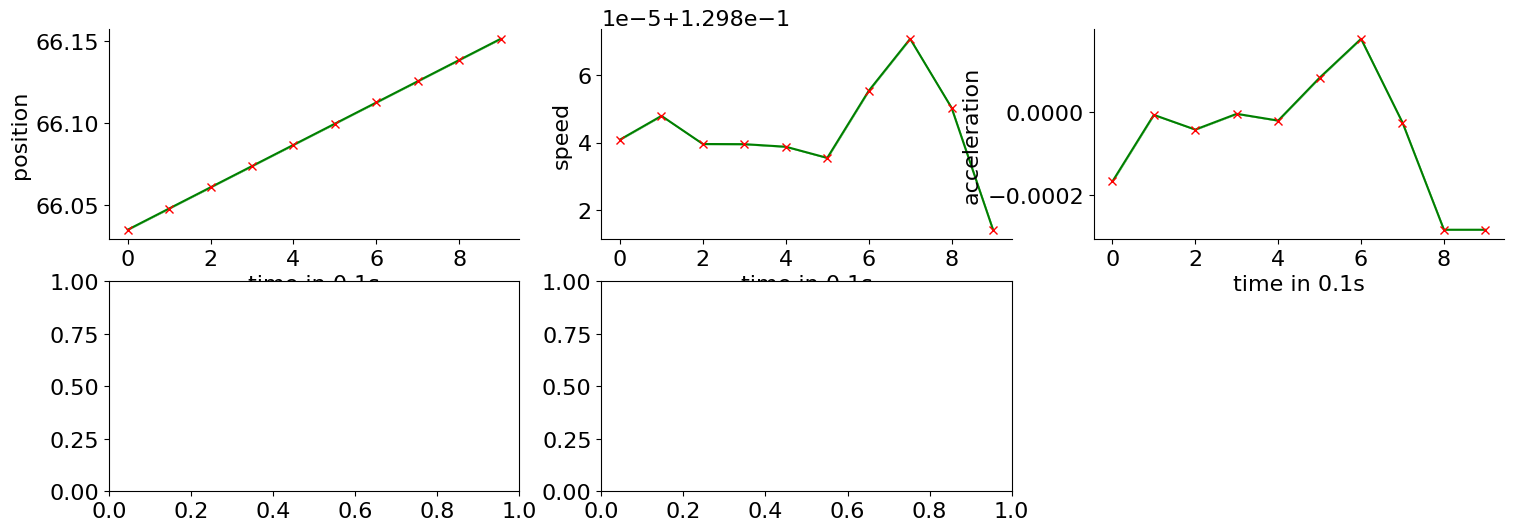

In [ ]:
visualize_trajectory(dataind=0) # change to visualize a different sample

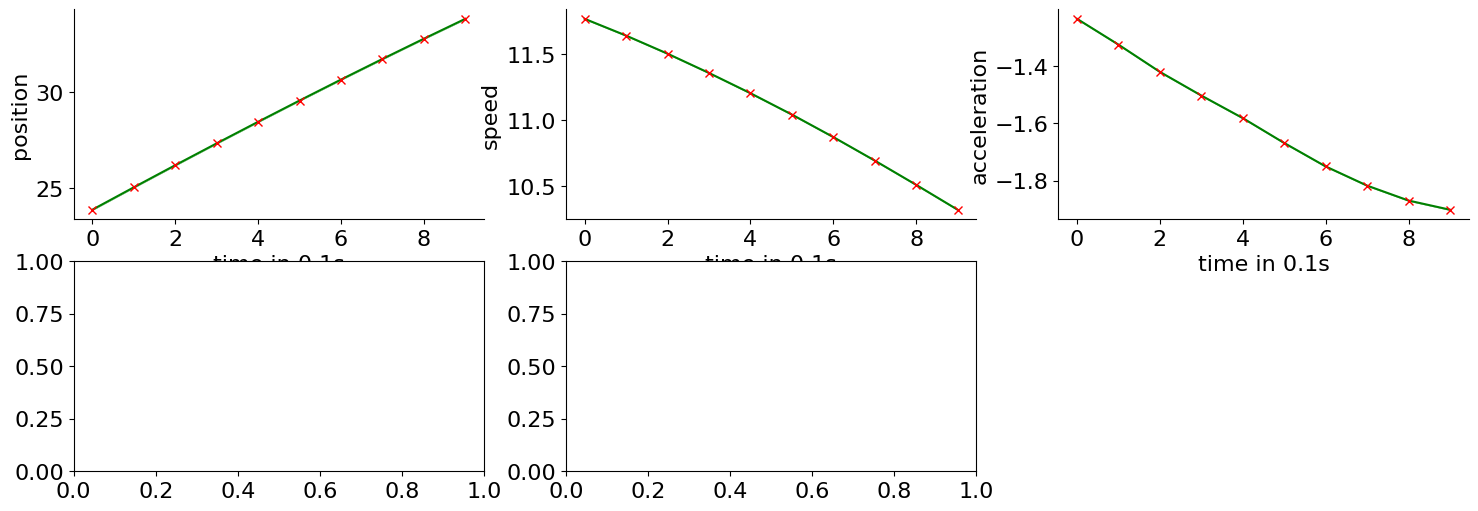

In [ ]:
visualize_trajectory(dataind=1) # change to visualize a different sample

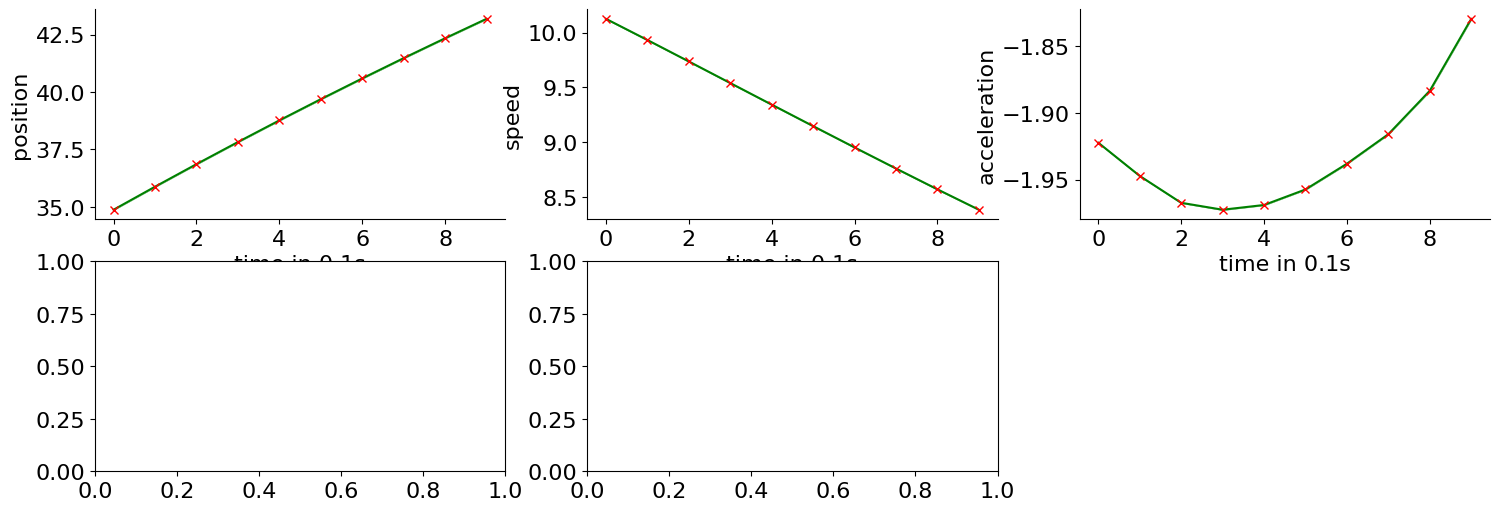

In [ ]:
visualize_trajectory(dataind=2) # change to visualize a different sample

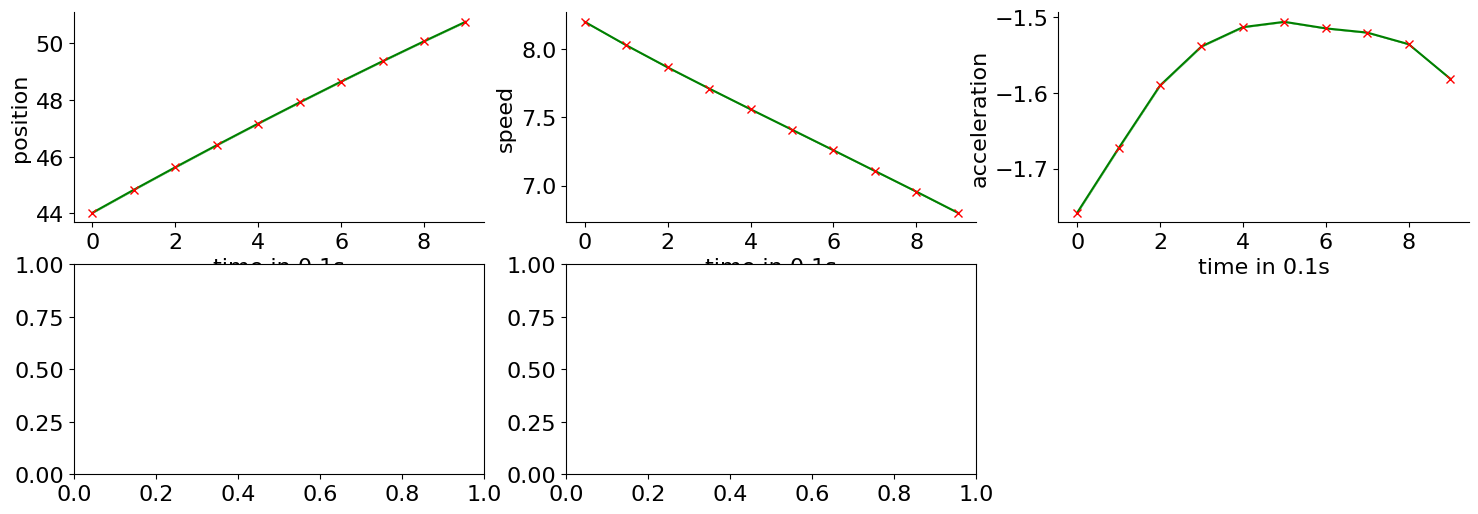

In [ ]:
visualize_trajectory(dataind=3) # change to visualize a different sample

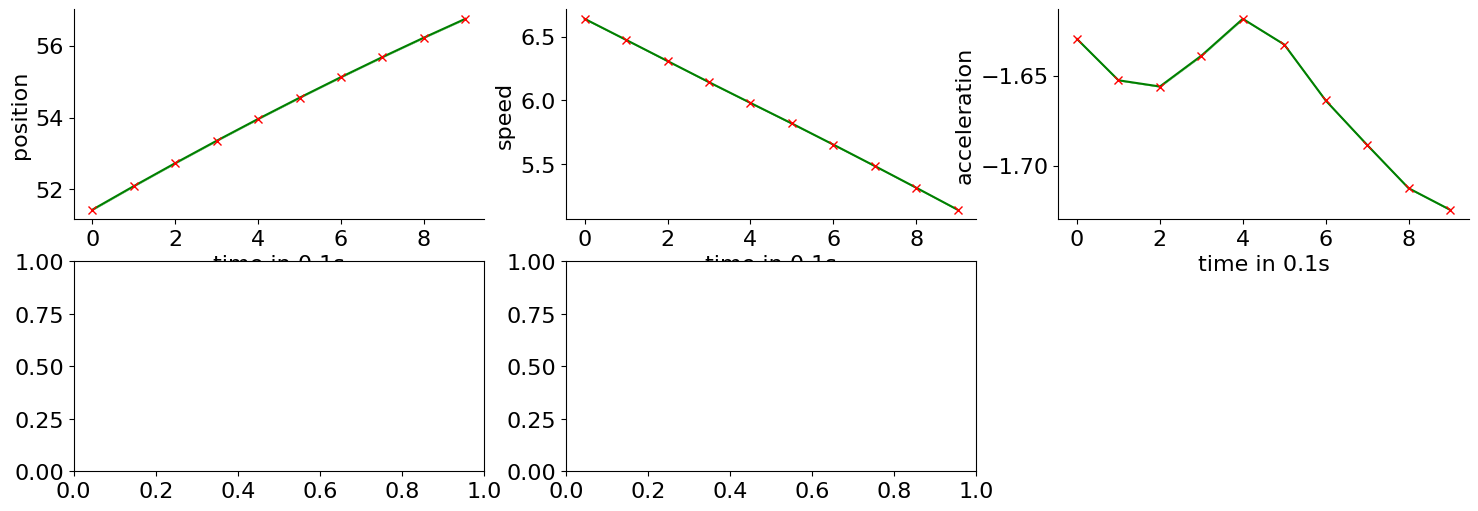

In [ ]:
visualize_trajectory(dataind=4) # change to visualize a different sample

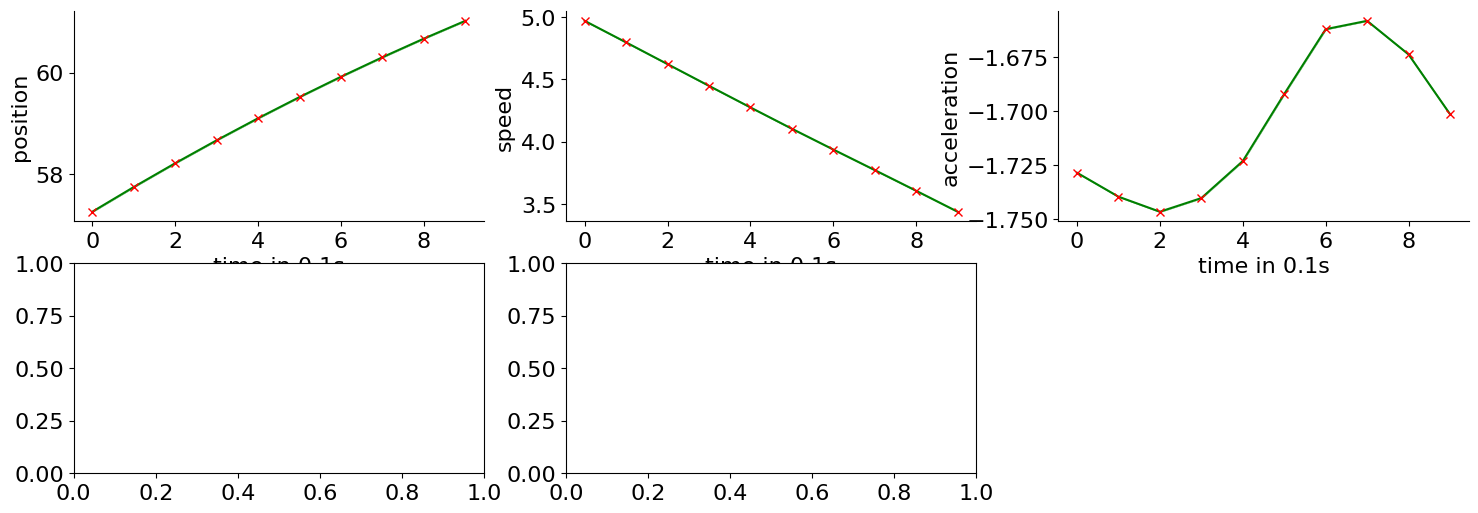

In [ ]:
visualize_trajectory(dataind=5) # change to visualize a different sample

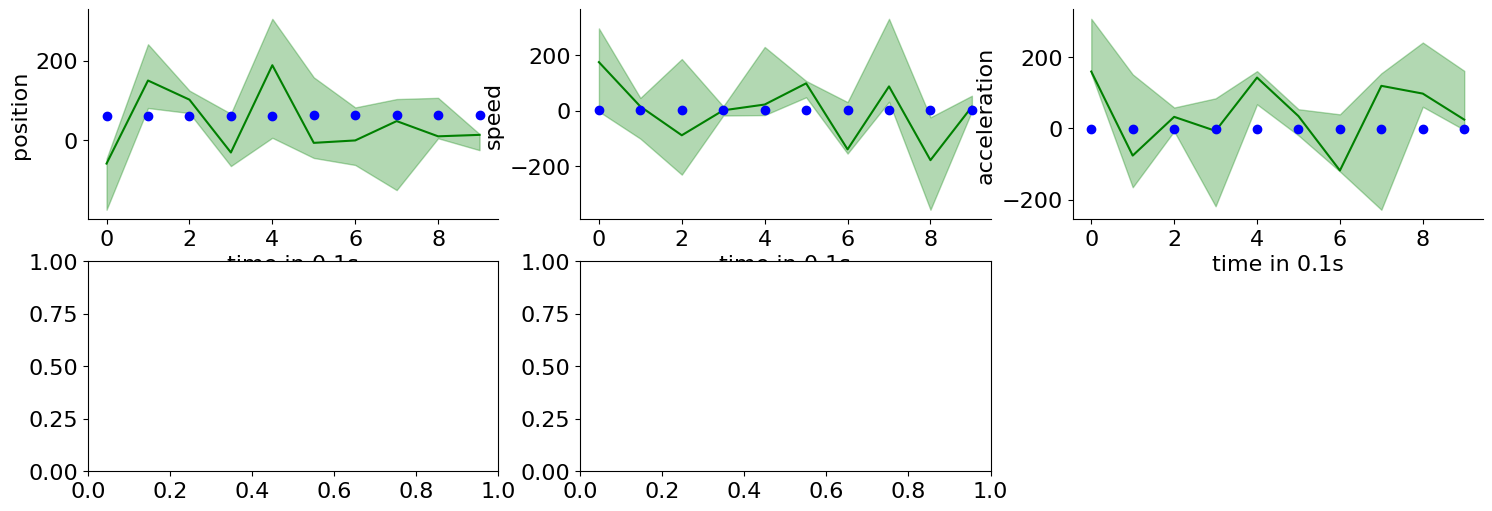

In [ ]:
visualize_trajectory(dataind=6) # change to visualize a different sample

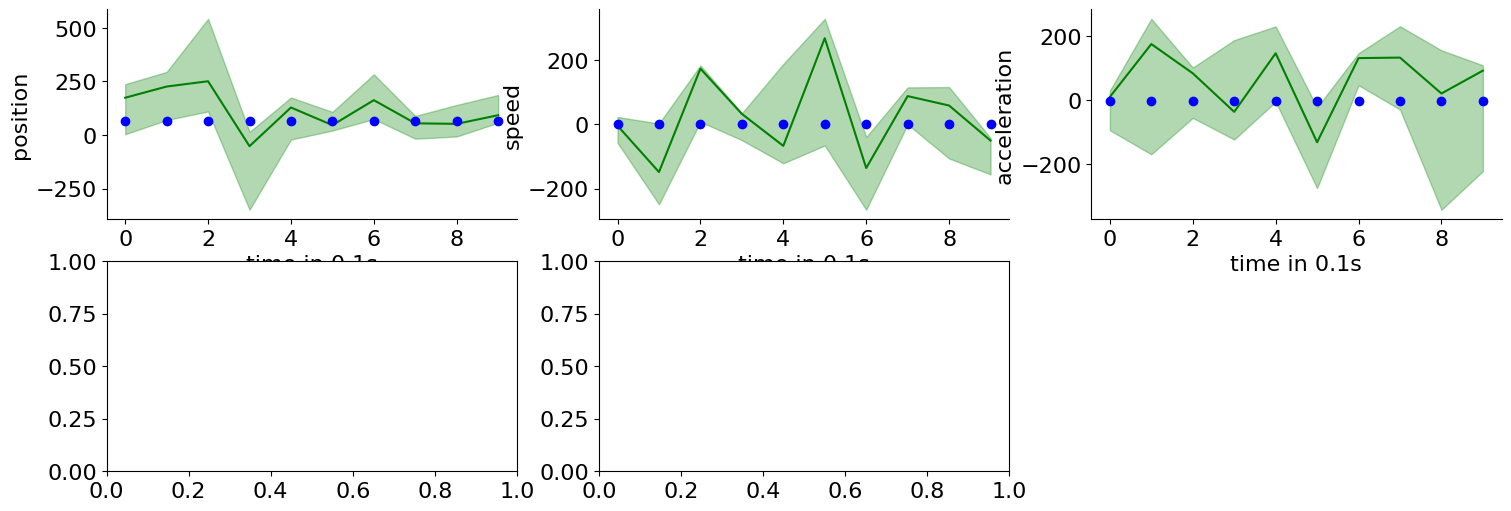

In [ ]:
visualize_trajectory(dataind=7) # change to visualize a different sample

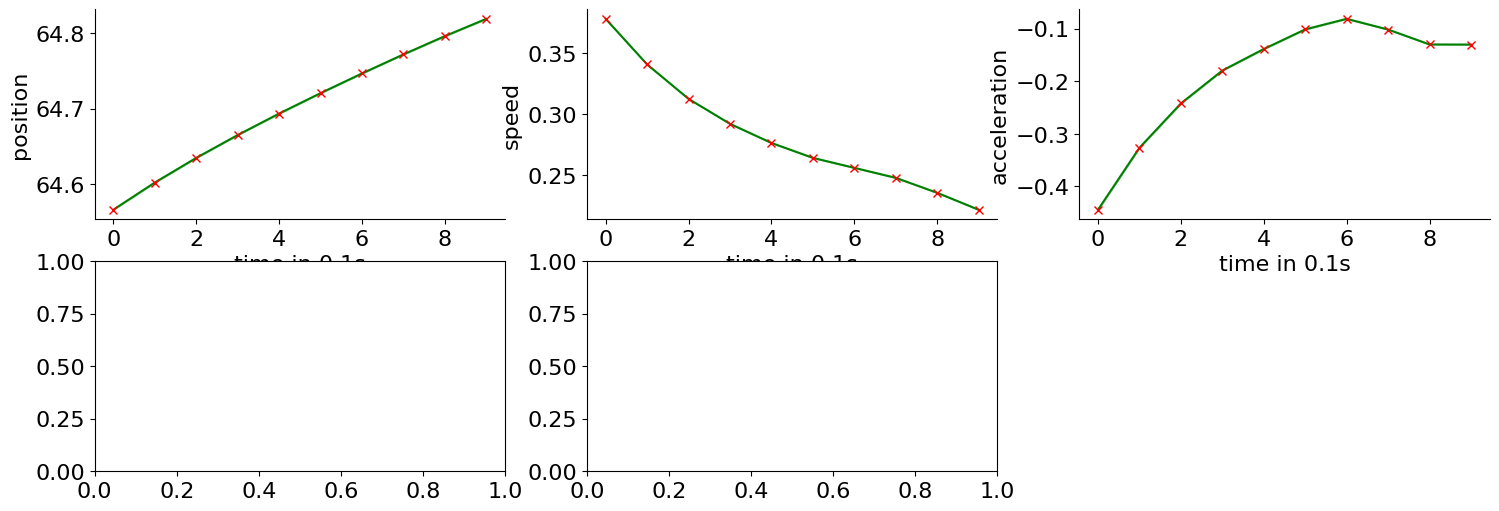

In [ ]:
visualize_trajectory(dataind=8) # change to visualize a different sample

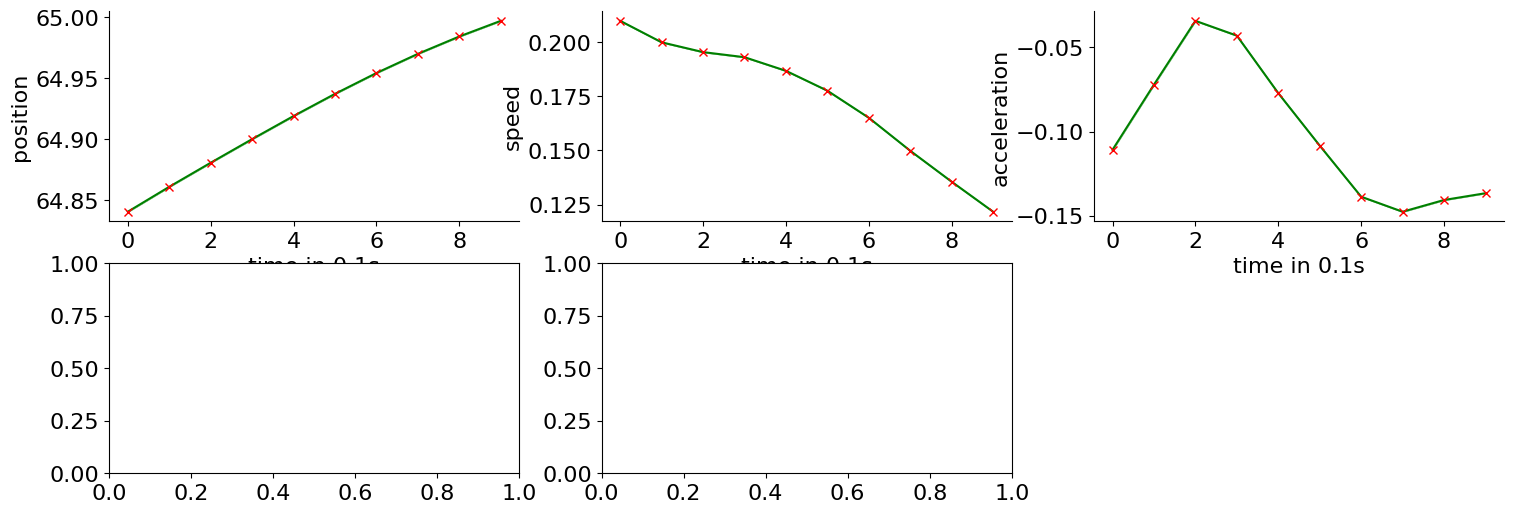

In [ ]:
visualize_trajectory(dataind=9) # change to visualize a different sample

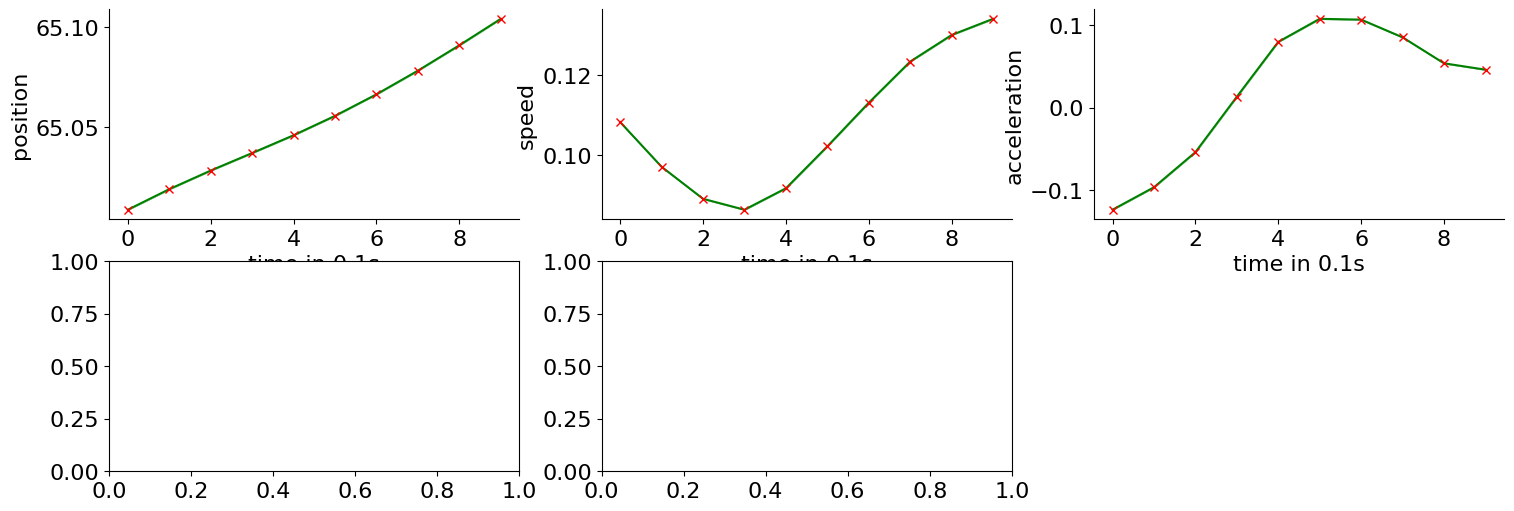

In [ ]:
visualize_trajectory(dataind=10) # change to visualize a different sample